**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**May, 2022**

Preprocessing scRNA-Seq of Placental explants


----

# Notebook to preprocess scRNA-Seq of Placental explants


In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline
import seaborn as sns
import seaborn as sb
from glob import iglob
import anndata
import matplotlib as mpl
import skmisc

    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= '../results/images/preprocessing/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


### Import data

In [2]:
data_dir = '/lustre/scratch117/cellgen/team292/er13/placental_explant/starsolo/data/'

meta = pd.read_csv(data_dir+'/meta_plac_exp_all.csv',index_col=0)
meta['donor'] = meta['donor'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  16


In [3]:
meta

,donor,termination,day,pcw
sample,,,,
Pla_HDBR10917729,Hrv97,medical,d5,5pcw
Pla_HDBR10917730,Hrv98,surgical,d0,9pcw
Pla_HDBR10917731,Hrv99,medical,d0,8pcw
Pla_HDBR10917732,Hrv98+Hrv99,surg_med,d3_d2,9pcw_8pcw
Pla_HDBR10917733,Hrv100,surgical,d0,5pcw
Pla_HDBR10917734,Hrv100,surgical,d2,5pcw
Pla_HDBR11345027,Hrv106,surgical,d0,17pcw
Pla_HDBR11345028,Hrv107,surgical,d0,11pcw
Pla_HDBR11345030,Hrv107,surgical,d2,11pcw


In [24]:
data_dir = '/lustre/scratch117/cellgen/team292/er13/placental_explant/starsolo/data/'

### Preprocessing


Quantify: 1) % mitochondrial genes; 2) total counts

In [4]:

#Patch to be removed as I am adding the latests samples that were aligned to the combined Hs+Tg genome
#----
meta2=meta[12:16]
meta= meta[0:12]

In [31]:

#Patch to be removed as I am adding the latests samples that were aligned to the combined Hs+Tg genome
#----
holder2 = []
for sample in meta2.index:
    print(sample)
    # Load 10x data as AnnData

    holder2.append(sc.read_10x_mtx(data_dir+sample+'/output/GeneFull/filtered/',var_names='gene_symbols',cache=False)) 
    #holder.append(sc.read_10x_mtx(data_dir+sample+'/soupX_filt/')) 
    #holder.append(sc.read_10x_h5(data_dir+sample+'/cellbender.out/cellbender_out_filtered.h5'))
    # Set names of observation as sample + _ + barcode/probe
    print('Original number of cells: {:d}'.format(holder2[-1].n_obs))
    
    holder2[-1].var_names_make_unique()
    holder2[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder2[-1].obs_names]
    
    
    # add in metadata
    holder2[-1].obs['sample'] = sample
    for val in meta.columns:
        holder2[-1].obs[val] = meta2[val][sample]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder2[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder2[-1].obs['percent_mito'] = np.sum(
         holder2[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder2[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder2[-1].obs['n_counts'] = holder2[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder2[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder2[-1].n_vars))

Pla_HDBR12808826
Original number of cells: 12394
Total number of cells: 12394
Total number of genes: 36601
Pla_HDBR12808827
Original number of cells: 12092
Total number of cells: 12092
Total number of genes: 36601
Pla_HDBR12808829
Original number of cells: 17577
Total number of cells: 17577
Total number of genes: 45238
Pla_HDBR12808831
Original number of cells: 17240
Total number of cells: 17240
Total number of genes: 45238


In [19]:
meta

,donor,termination,day,pcw
sample,,,,
Pla_HDBR10917729,Hrv97,medical,d5,5pcw
Pla_HDBR10917730,Hrv98,surgical,d0,9pcw
Pla_HDBR10917731,Hrv99,medical,d0,8pcw
Pla_HDBR10917732,Hrv98+Hrv99,surg_med,d3_d2,9pcw_8pcw
Pla_HDBR10917733,Hrv100,surgical,d0,5pcw
Pla_HDBR10917734,Hrv100,surgical,d2,5pcw
Pla_HDBR11345027,Hrv106,surgical,d0,17pcw
Pla_HDBR11345028,Hrv107,surgical,d0,11pcw
Pla_HDBR11345030,Hrv107,surgical,d2,11pcw


In [20]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData

    holder.append(sc.read_10x_mtx(data_dir+sample+'/output/GeneFull/filtered/',var_names='gene_symbols',cache=True)) 
    #holder.append(sc.read_10x_mtx(data_dir+sample+'/soupX_filt/')) 
    #holder.append(sc.read_10x_h5(data_dir+sample+'/cellbender.out/cellbender_out_filtered.h5'))
    # Set names of observation as sample + _ + barcode/probe
    print('Original number of cells: {:d}'.format(holder[-1].n_obs))
    
    holder[-1].var_names_make_unique()
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    
    
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
         holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

Pla_HDBR10917729
Original number of cells: 10057
Total number of cells: 10057
Total number of genes: 36601
Pla_HDBR10917730
Original number of cells: 15037
Total number of cells: 15037
Total number of genes: 36601
Pla_HDBR10917731
Original number of cells: 13402
Total number of cells: 13402
Total number of genes: 36601
Pla_HDBR10917732
Original number of cells: 27334
Total number of cells: 27334
Total number of genes: 36601
Pla_HDBR10917733
Original number of cells: 20505
Total number of cells: 20505
Total number of genes: 36601
Pla_HDBR10917734
Original number of cells: 3856
Total number of cells: 3856
Total number of genes: 36601
Pla_HDBR11345027
Original number of cells: 13162
Total number of cells: 13162
Total number of genes: 36601
Pla_HDBR11345028
Original number of cells: 14911
Total number of cells: 14911
Total number of genes: 36601
Pla_HDBR11345030
Original number of cells: 24568
Total number of cells: 24568
Total number of genes: 36601
Pla_HDBR11345031
Original number of cel

In [43]:
holder2[3]

View of AnnData object with n_obs × n_vars = 17240 × 36601
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types'

In [47]:
holder[1]

AnnData object with n_obs × n_vars = 13517 × 36601
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types'

In [41]:

# Patch to be removed as I am adding the latests samples that were aligned to the combined Hs+Tg genome
#----

#Subsetting only the human genes
holder2[2] = holder2[2][:, list(holder[0].var.index)]
holder2[3] = holder2[3][:, list(holder[0].var.index)]



#appending the objest to the holder list
holder.append(holder2[0])
holder.append(holder2[1])
holder.append(holder2[2])
holder.append(holder2[3])

In [53]:
len(holder)

16

In [7]:
#Original cells
10057+15037+13402+27334+20505+3856+13162+14911+24568+21737+20323+13517+12366+12109+17577+17240

257701

In [54]:
# confirm N samples
print(len(holder))
# merge datasets by taking the intersection of cells found between nucleis and cells 
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)

# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

16


AnnData object with n_obs × n_vars = 257712 × 36601
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids', 'feature_types'

In [55]:
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC141272.1,ENSG00000277836,Gene Expression
AC023491.2,ENSG00000278633,Gene Expression
AC007325.1,ENSG00000276017,Gene Expression
AC007325.4,ENSG00000278817,Gene Expression


Basic filtering. 
Filter:
1) cells (< 100 genes);
2) genes (< 3 cells)

In [ ]:
# Filter cells with less than 100 genes expressed
sc.pp.filter_cells(adata, min_genes=100)
# Filer genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

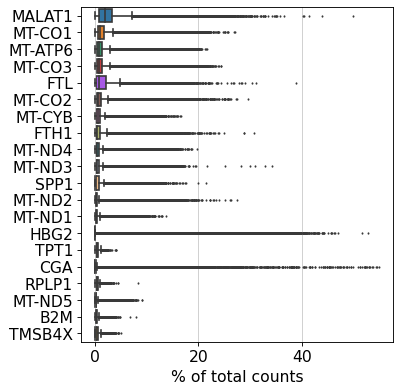

In [70]:
sc.pl.highest_expr_genes(adata, n_top=20)

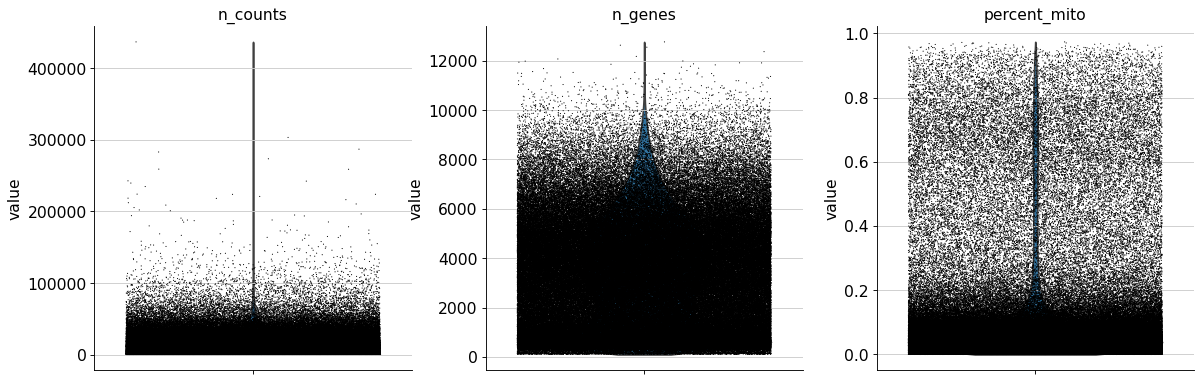

In [72]:
sc.pl.violin(adata, ['n_counts','n_genes', 'percent_mito'], #'n_genes', 
             jitter=0.4, multi_panel=True)

In [62]:
adata

AnnData object with n_obs × n_vars = 257493 × 32743
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [63]:
adata.write('../../starsolo/data/S1_preprocessed_noNormalized_adata_20220522.h5ad')

In [36]:
adata=sc.read('../../starsolo/data/S1_preprocessed_noNormalized_adata.h5ad')

# Souporcell
Adding another column with deconvolution from souporcell

In [64]:
samples = list(np.unique(adata.obs['sample']))

In [65]:
samples = ['Pla_HDBR10917732','Pla_HDBR12808829','Pla_HDBR12808831']

In [66]:
samples

['Pla_HDBR10917732', 'Pla_HDBR12808829', 'Pla_HDBR12808831']

In [73]:
# reading in souporcell outputs
# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path = data_dir+'souporcell/'+sample+'/clusters.tsv' #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #aadind the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR10917732
sample Pla_HDBR12808829
sample Pla_HDBR12808831


In [68]:
adata.obs['sample_barcode'] = adata.obs.index

In [69]:
adata.obs.head()

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode
Pla_HDBR10917729_AAACCCACATCGAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,1938,Pla_HDBR10917729_AAACCCACATCGAACT
Pla_HDBR10917729_AAACCCAGTAAGACCG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,449,Pla_HDBR10917729_AAACCCAGTAAGACCG
Pla_HDBR10917729_AAACCCAGTGGGATTG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,779,Pla_HDBR10917729_AAACCCAGTGGGATTG
Pla_HDBR10917729_AAACCCATCAACACCA,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0,109,Pla_HDBR10917729_AAACCCATCAACACCA
Pla_HDBR10917729_AAACGAAAGCCTAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047304,3023.0,0,1178,Pla_HDBR10917729_AAACGAAAGCCTAACT


In [ ]:
### Function to add the souporcell cluster
####

def add_souporcell_id(adata_obj, cell_id, samples):
    '''
    Function to add the souporcell status (e.g. 0,1, not pooled, etc.) to the cells
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        samples: list of samples that were pooled. Usually not all samples are multiplexed.
    
    '''
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #print('sample',sample, 'barcode', cell_id)
    
    if curr_sample in samples:
        #extracts the table contained in the indicated key of the dictionary
        curr_souporcell_table = souporcell_clusters[curr_sample]
        
        if (cell_id in list(curr_souporcell_table.index)): #checking that the cells are into the data
            curr_assign = souporcell_clusters[curr_sample].loc[cell_id,'assignment']
            #print('returning',curr_assign)
            return(curr_assign)

        else:
            # cell barcode is filtered by souporcell
            return('filtered_by_souporcell')
    else:
        return('not_pooled')

In [76]:
%%time

adata.obs['souporcell_id'] = adata.obs['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x,samples))

CPU times: user 1min 25s, sys: 0 ns, total: 1min 25s
Wall time: 1min 25s


In [77]:
adata.obs.head()

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode,souporcell_id
Pla_HDBR10917729_AAACCCACATCGAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,1938,Pla_HDBR10917729_AAACCCACATCGAACT,not_pooled
Pla_HDBR10917729_AAACCCAGTAAGACCG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,449,Pla_HDBR10917729_AAACCCAGTAAGACCG,not_pooled
Pla_HDBR10917729_AAACCCAGTGGGATTG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,779,Pla_HDBR10917729_AAACCCAGTGGGATTG,not_pooled
Pla_HDBR10917729_AAACCCATCAACACCA,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0,109,Pla_HDBR10917729_AAACCCATCAACACCA,not_pooled
Pla_HDBR10917729_AAACGAAAGCCTAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047304,3023.0,0,1178,Pla_HDBR10917729_AAACGAAAGCCTAACT,not_pooled


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '0'),
  Text(2, 0, '1/0'),
  Text(3, 0, 'filtered_by_souporcell'),
  Text(4, 0, '0/1')])

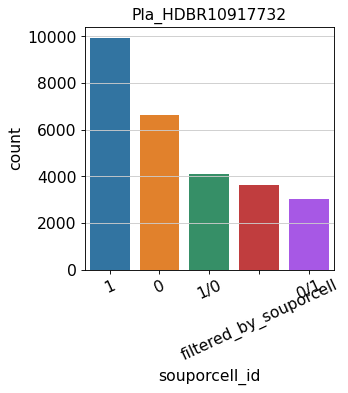

In [102]:
sample='Pla_HDBR10917732'
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['souporcell_id'],
                order=adata[adata.obs['sample'] == sample].obs['souporcell_id'].value_counts().index).set_title(sample)

plt.savefig(fig_path+'countplot_souporcell_id'+sample+'.pdf')
plt.xticks(rotation=25)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, '2'),
  Text(1, 0, '1'),
  Text(2, 0, '2/1'),
  Text(3, 0, '1/2'),
  Text(4, 0, '1/3'),
  Text(5, 0, '2/0'),
  Text(6, 0, '0'),
  Text(7, 0, '2/3'),
  Text(8, 0, '3'),
  Text(9, 0, '1/0'),
  Text(10, 0, '0/3'),
  Text(11, 0, '3/2'),
  Text(12, 0, '3/1'),
  Text(13, 0, '0/2'),
  Text(14, 0, '0/1'),
  Text(15, 0, '3/0')])

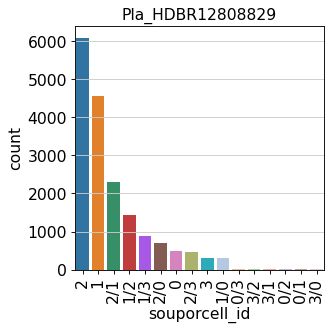

In [96]:
sample='Pla_HDBR12808829'
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['souporcell_id'],
                order=adata[adata.obs['sample'] == sample].obs['souporcell_id'].value_counts().index).set_title(sample)

plt.savefig(fig_path+'countplot_souporcell_id'+sample+'.pdf')
plt.xticks(rotation=90)


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '3'),
  Text(1, 0, '2'),
  Text(2, 0, '3/2'),
  Text(3, 0, '2/3'),
  Text(4, 0, '3/1'),
  Text(5, 0, '3/0'),
  Text(6, 0, '2/0'),
  Text(7, 0, '2/1'),
  Text(8, 0, '0'),
  Text(9, 0, '1'),
  Text(10, 0, '0/3')])

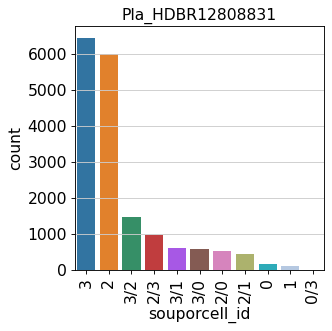

In [97]:

sample='Pla_HDBR12808831'
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['souporcell_id'],
                order=adata[adata.obs['sample'] == sample].obs['souporcell_id'].value_counts().index).set_title(sample)

plt.savefig(fig_path+'countplot_souporcell_id'+sample+'.pdf')
plt.xticks(rotation=90)

In [103]:
#Deleting the cells filtered by soc
adata= adata[adata.obs['souporcell_id'] != 'filtered_by_souporcell']



/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [105]:
adata

View of AnnData object with n_obs × n_vars = 253880 × 32743
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'souporcell_id'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [106]:
### Building a dictionary with the identity of the cluster in each one of the samples.
### It has the structure SAMPLE:{Cluster:Donor,Cluster:Donor}

identity_dict={
    "Pla_HDBR10917732":{'0':'Hrv99','1':'Hrv98'},
    "Pla_HDBR12808829":{'0':'Hrv142','1':'Hrv142','2':'Hrv141','3':'Hrv141'},
    "Pla_HDBR12808831":{'0':'Hrv141','1':'Hrv142','2':'Hrv142','3':'Hrv141'}
}

In [88]:
adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR12808831']

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode,souporcell_id
Pla_HDBR12808831_AAACCCAAGAGCCGAT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.009198,5110.0,15,2538,Pla_HDBR12808831_AAACCCAAGAGCCGAT,2
Pla_HDBR12808831_AAACCCAAGAGTGTGC,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.011982,1085.0,15,662,Pla_HDBR12808831_AAACCCAAGAGTGTGC,2/3
Pla_HDBR12808831_AAACCCAAGCATGGGT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.037111,997.0,15,623,Pla_HDBR12808831_AAACCCAAGCATGGGT,3
Pla_HDBR12808831_AAACCCAAGGGCAGAG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.036839,3176.0,15,1819,Pla_HDBR12808831_AAACCCAAGGGCAGAG,3
Pla_HDBR12808831_AAACCCAAGTCGGCCT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.003849,8054.0,15,2631,Pla_HDBR12808831_AAACCCAAGTCGGCCT,3/1
...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR12808831_TTTGTTGTCGTACACA,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.108353,8943.0,15,3200,Pla_HDBR12808831_TTTGTTGTCGTACACA,3
Pla_HDBR12808831_TTTGTTGTCTCGACGG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.021751,19355.0,15,4116,Pla_HDBR12808831_TTTGTTGTCTCGACGG,2
Pla_HDBR12808831_TTTGTTGTCTCGGCTT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.391127,1713.0,15,587,Pla_HDBR12808831_TTTGTTGTCTCGGCTT,2/3
Pla_HDBR12808831_TTTGTTGTCTGTGCTC,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.039958,23550.0,15,5239,Pla_HDBR12808831_TTTGTTGTCTGTGCTC,3


In [79]:
def decode_donors(adata_obj, cell_id, identity_dict,samples):

    '''
    Function to add the true identity to the multiplexed samples. The souporcell samples are changed
    to the real names of the clusters(e.g. 0= Hrv99, 1=Hrv98).
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        identity_dict: dictionary with the identity of each cluster per each sample. It has the structure sample:{cluster:donor}.
        samples: list of samples to be considered in the function. Not all samples are multiplexed
    '''
    
    
    #sample name
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #cluster name
    curr_souporcell_cluster = adata_obj.obs.loc[cell_id, 'souporcell_id']

    if curr_sample in samples:
        if '/' in curr_souporcell_cluster:
            #this means that the cell could not be assigned to a cluster (e.g. 2/3), therefore it is considered as a doublet
            return('souporcell_doublet')

        else:
            return(identity_dict[curr_sample][curr_souporcell_cluster])



In [107]:
%%time

adata.obs['donor_deconv'] = adata.obs['sample_barcode'].apply(lambda x: decode_donors(adata,x,identity_dict, samples))

#adata.obs['donor_deconv'] = adata.obs['sample_barcode'].apply(lambda x: decode_donors(adata,x))

Trying to set attribute `.obs` of view, copying.


CPU times: user 9.14 s, sys: 3.51 s, total: 12.7 s
Wall time: 12.7 s


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '1/0'), Text(3, 0, '0/1')])

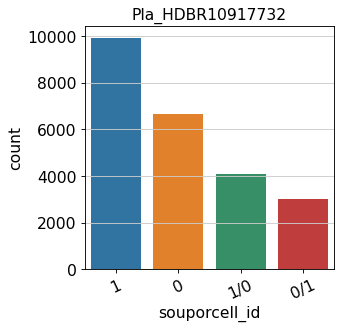

In [108]:
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['souporcell_id'],
                order=adata[adata.obs['sample'] == sample].obs['souporcell_id'].value_counts().index).set_title(sample)

plt.xticks(rotation=25)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


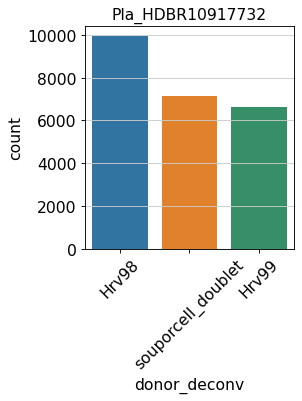

In [109]:
sample='Pla_HDBR10917732'
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['donor_deconv'],
                order=adata[adata.obs['sample'] == sample].obs['donor_deconv'].value_counts().index).set_title(sample)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(fig_path+'countplot_donor_deconv'+sample+'.pdf')

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


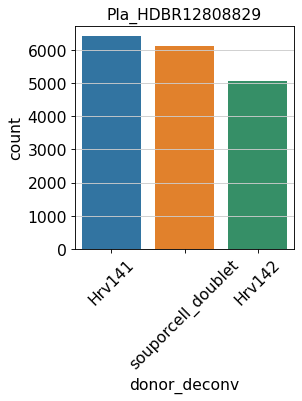

In [111]:
sample='Pla_HDBR12808829'
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['donor_deconv'],
                order=adata[adata.obs['sample'] == sample].obs['donor_deconv'].value_counts().index).set_title(sample)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(fig_path+'countplot_donor_deconv'+sample+'.pdf')

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


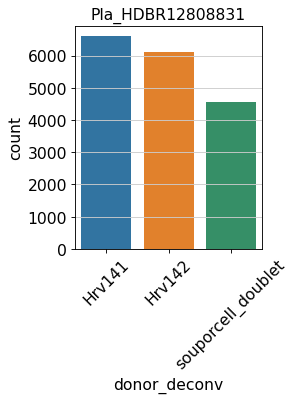

In [112]:
sample='Pla_HDBR12808831'
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['donor_deconv'],
                order=adata[adata.obs['sample'] == sample].obs['donor_deconv'].value_counts().index).set_title(sample)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(fig_path+'countplot_donor_deconv'+sample+'.pdf')

In [114]:
# Number of cells after the souporcell doublet filtering
#len(adata.obs)

print('Total number of doublets: {:d}'.format(adata.n_obs))

print('Total number of doublets: {:d}'.format(len(adata.obs.loc[adata.obs['donor_deconv'] == "souporcell_doublet"])))

Total number of doublets: 253880
Total number of doublets: 17814


Now that I have deconvoluted the donors, I will include the non-multiplexed cells into the donor_deconv column

In [115]:
adata.obs

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode,souporcell_id,donor_deconv
Pla_HDBR10917729_AAACCCACATCGAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,1938,Pla_HDBR10917729_AAACCCACATCGAACT,not_pooled,None
Pla_HDBR10917729_AAACCCAGTAAGACCG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,449,Pla_HDBR10917729_AAACCCAGTAAGACCG,not_pooled,None
Pla_HDBR10917729_AAACCCAGTGGGATTG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,779,Pla_HDBR10917729_AAACCCAGTGGGATTG,not_pooled,None
Pla_HDBR10917729_AAACCCATCAACACCA,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0,109,Pla_HDBR10917729_AAACCCATCAACACCA,not_pooled,None
Pla_HDBR10917729_AAACGAAAGCCTAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047304,3023.0,0,1178,Pla_HDBR10917729_AAACGAAAGCCTAACT,not_pooled,None
...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR12808831_TTTGTTGTCGTACACA,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.108353,8943.0,15,3200,Pla_HDBR12808831_TTTGTTGTCGTACACA,3,Hrv141
Pla_HDBR12808831_TTTGTTGTCTCGACGG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.021751,19355.0,15,4116,Pla_HDBR12808831_TTTGTTGTCTCGACGG,2,Hrv142
Pla_HDBR12808831_TTTGTTGTCTCGGCTT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.391127,1713.0,15,587,Pla_HDBR12808831_TTTGTTGTCTCGGCTT,2/3,souporcell_doublet
Pla_HDBR12808831_TTTGTTGTCTGTGCTC,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.039958,23550.0,15,5239,Pla_HDBR12808831_TTTGTTGTCTGTGCTC,3,Hrv141


#### Correction of column values in metadata after deconvolution

In [122]:
def donor_assing(adata_obj, cell_id):
    
    '''
    Function that assings a donor ID to the cells that were pooled
    
    input
        adata_obj: adata object
        cell_id:

    '''
    
    #Donor deconvoluted of the current cell
    curr_donor_deconv = adata_obj.obs.loc[cell_id, 'donor_deconv']
    #Donor of the current cell (before deconvolution)
    curr_donor = adata_obj.obs.loc[cell_id, 'donor']
    
    # donor ID from 'donor_id' column
    
    #If the curr_donor_deconv is None, then the function willl return the donor before deconvolution
    # Otherwise it will return the same donor in the donor_deconv column. Which is the real donor. 
    if curr_donor_deconv == None:
        return(curr_donor)
    
    else:
        return(curr_donor_deconv)

    
    
    
    
def column_deconvCorrector(adata_obj, cell_id, column):
    
    '''
    Function that corrects values in a column of cell metadata with the correct names after deconvolution
    
    input
        adata_obj: adata object
        cell_id: cell id
        column: column to correct
    '''
    
    #sample, use as first filter
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    
    # donor ID from 'donor_id' column
    
    
    #Specific case for this sample.  Samples aremultiplexed
    # Pla_HDBR12808826 (Hrv141), and 1 to Pla_HDBR12808827 (Hrv142)
    
    # Current value in the column in this cell (before deconvolution)
    curr_columnValue = adata_obj.obs.loc[cell_id, column]
    
    
    #only doing this for the samples that were pooled
    if curr_sample in samples:
        #Donor deconvoluted of the current cell
        curr_donor_deconv = adata_obj.obs.loc[cell_id, 'donor_souporcell']

        
        #return(identity_dict[curr_sample][curr_souporcell_cluster])
    
    
        if curr_donor_deconv == 'Hrv99':
            if column == 'day':
                return('d2')

            else:
                #Here I obtain the list of values corresponding to the correct identity and get the
                # value corresponding to the column to correct
                correct_value = list(set(adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR10917731',column]))[0]
                return(correct_value)

            
        elif curr_donor_deconv == 'Hrv98':
            #The day differs per run, so I will manually indicate the right day here
            if column == 'day':
                return('d3')

            else:
                correct_value = list(set(adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR10917730',column]))[0]
                return(correct_value)



        elif curr_donor_deconv == 'Hrv141':
            #The day differs per run, so I will manually indicate the right day here
            if column == 'day':
                return('d2')
            
            else:
                #Here I obtain the list of values corresponding to the correct identity and get the
                # value corresponding to the column to correct
                correct_value = list(set(adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR12808826',column]))[0]
                return(correct_value)
        
        
        elif curr_donor_deconv == 'Hrv142':
            #The day differs per run, so I will manually indicate the right day here
            if column == 'day':
                return('d2')
            
            else:
                correct_value = list(set(adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR12808827',column]))[0]
                return(correct_value)
        
        # this is the sitation when the cell was identified as a doublet
        else:
            return(curr_columnValue) #keeping the original value in that column
        
    
    else:
        return(curr_columnValue)




In [118]:
#applying the donor_assing function to the data. The donor names will be stored in the new column donor_clean
adata.obs['donor_souporcell'] = adata.obs['sample_barcode'].apply(lambda x: donor_assing(adata,x))

In [120]:
adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR10917730']

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode,souporcell_id,donor_deconv,donor_souporcell
Pla_HDBR10917730_AAACCCAAGACGACGT,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.036525,1807.0,1,958,Pla_HDBR10917730_AAACCCAAGACGACGT,not_pooled,None,Hrv98
Pla_HDBR10917730_AAACCCAAGAGGCGGA,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.046415,15943.0,1,4006,Pla_HDBR10917730_AAACCCAAGAGGCGGA,not_pooled,None,Hrv98
Pla_HDBR10917730_AAACCCAAGCCTCTCT,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.026982,2409.0,1,1556,Pla_HDBR10917730_AAACCCAAGCCTCTCT,not_pooled,None,Hrv98
Pla_HDBR10917730_AAACCCAAGGCACTAG,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.000377,2656.0,1,1232,Pla_HDBR10917730_AAACCCAAGGCACTAG,not_pooled,None,Hrv98
Pla_HDBR10917730_AAACCCAAGGCTGAAC,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.019171,9911.0,1,3199,Pla_HDBR10917730_AAACCCAAGGCTGAAC,not_pooled,None,Hrv98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR10917730_TTTGTTGTCACATTGG,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.023450,8870.0,1,3401,Pla_HDBR10917730_TTTGTTGTCACATTGG,not_pooled,None,Hrv98
Pla_HDBR10917730_TTTGTTGTCCTAGCCT,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.022271,20340.0,1,4917,Pla_HDBR10917730_TTTGTTGTCCTAGCCT,not_pooled,None,Hrv98
Pla_HDBR10917730_TTTGTTGTCGATGCTA,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.002095,1909.0,1,249,Pla_HDBR10917730_TTTGTTGTCGATGCTA,not_pooled,None,Hrv98
Pla_HDBR10917730_TTTGTTGTCGCTAAAC,Pla_HDBR10917730,Hrv98,surgical,d0,9pcw,0.021750,16138.0,1,4208,Pla_HDBR10917730_TTTGTTGTCGCTAAAC,not_pooled,None,Hrv98


In [121]:
#adata.obs.loc[adata.obs['sample'] != 'Pla_HDBR10917732']
adata.obs

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode,souporcell_id,donor_deconv,donor_souporcell
Pla_HDBR10917729_AAACCCACATCGAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,1938,Pla_HDBR10917729_AAACCCACATCGAACT,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCAGTAAGACCG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,449,Pla_HDBR10917729_AAACCCAGTAAGACCG,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCAGTGGGATTG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,779,Pla_HDBR10917729_AAACCCAGTGGGATTG,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCATCAACACCA,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0,109,Pla_HDBR10917729_AAACCCATCAACACCA,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACGAAAGCCTAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047304,3023.0,0,1178,Pla_HDBR10917729_AAACGAAAGCCTAACT,not_pooled,None,Hrv97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR12808831_TTTGTTGTCGTACACA,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.108353,8943.0,15,3200,Pla_HDBR12808831_TTTGTTGTCGTACACA,3,Hrv141,Hrv141
Pla_HDBR12808831_TTTGTTGTCTCGACGG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.021751,19355.0,15,4116,Pla_HDBR12808831_TTTGTTGTCTCGACGG,2,Hrv142,Hrv142
Pla_HDBR12808831_TTTGTTGTCTCGGCTT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.391127,1713.0,15,587,Pla_HDBR12808831_TTTGTTGTCTCGGCTT,2/3,souporcell_doublet,souporcell_doublet
Pla_HDBR12808831_TTTGTTGTCTGTGCTC,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.039958,23550.0,15,5239,Pla_HDBR12808831_TTTGTTGTCTGTGCTC,3,Hrv141,Hrv141


In [123]:
#applying the column_deconvCorrector function to the data. The column values for the
# deconvoluted samples will be corrected
adata.obs['pcw'] = adata.obs['sample_barcode'].apply(lambda x: column_deconvCorrector(adata,x,'pcw'))
adata.obs['termination'] = adata.obs['sample_barcode'].apply(lambda x: column_deconvCorrector(adata,x,'termination'))
adata.obs['day'] = adata.obs['sample_barcode'].apply(lambda x: column_deconvCorrector(adata,x,'day'))

In [125]:
adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR12808831']

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode,souporcell_id,donor_deconv,donor_souporcell
Pla_HDBR12808831_AAACCCAAGAGCCGAT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,12pcw,0.009198,5110.0,15,2538,Pla_HDBR12808831_AAACCCAAGAGCCGAT,2,Hrv142,Hrv142
Pla_HDBR12808831_AAACCCAAGAGTGTGC,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.011982,1085.0,15,662,Pla_HDBR12808831_AAACCCAAGAGTGTGC,2/3,souporcell_doublet,souporcell_doublet
Pla_HDBR12808831_AAACCCAAGCATGGGT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw,0.037111,997.0,15,623,Pla_HDBR12808831_AAACCCAAGCATGGGT,3,Hrv141,Hrv141
Pla_HDBR12808831_AAACCCAAGGGCAGAG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw,0.036839,3176.0,15,1819,Pla_HDBR12808831_AAACCCAAGGGCAGAG,3,Hrv141,Hrv141
Pla_HDBR12808831_AAACCCAAGTCGGCCT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.003849,8054.0,15,2631,Pla_HDBR12808831_AAACCCAAGTCGGCCT,3/1,souporcell_doublet,souporcell_doublet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR12808831_TTTGTTGTCGTACACA,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw,0.108353,8943.0,15,3200,Pla_HDBR12808831_TTTGTTGTCGTACACA,3,Hrv141,Hrv141
Pla_HDBR12808831_TTTGTTGTCTCGACGG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,12pcw,0.021751,19355.0,15,4116,Pla_HDBR12808831_TTTGTTGTCTCGACGG,2,Hrv142,Hrv142
Pla_HDBR12808831_TTTGTTGTCTCGGCTT,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.391127,1713.0,15,587,Pla_HDBR12808831_TTTGTTGTCTCGGCTT,2/3,souporcell_doublet,souporcell_doublet
Pla_HDBR12808831_TTTGTTGTCTGTGCTC,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw,0.039958,23550.0,15,5239,Pla_HDBR12808831_TTTGTTGTCTGTGCTC,3,Hrv141,Hrv141


In [127]:
set(list(adata.obs.donor))

{'Hrv100',
 'Hrv106',
 'Hrv107',
 'Hrv111',
 'Hrv124',
 'Hrv141',
 'Hrv141+Hrv142',
 'Hrv142',
 'Hrv97',
 'Hrv98',
 'Hrv98+Hrv99',
 'Hrv99'}

In [128]:
#Check the donor categories
set(list(adata.obs.donor_souporcell))

{'Hrv100',
 'Hrv106',
 'Hrv107',
 'Hrv111',
 'Hrv124',
 'Hrv141',
 'Hrv142',
 'Hrv97',
 'Hrv98',
 'Hrv99',
 'souporcell_doublet'}

In [129]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 253880


# Scrublet

In [10]:
data_dir = '/lustre/scratch117/cellgen/team292/er13/placental_explant/starsolo/data/'

meta = pd.read_csv(data_dir+'/meta_plac_exp_all.csv',index_col=0)
meta['donor'] = meta['donor'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  16


In [11]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    #reading the scrublet scores done in S0
    scrdf.append(pd.read_csv('../data/scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'soupX.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]
# In scrublet the significant p-value mark doublets
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

In [12]:
print('Total number of doublets: {:d}'.format(len(adata.obs.loc[adata.obs['is_doublet'] == True])))

Total number of doublets: 7931


In [132]:
#adata = adata[adata.obs['is_doublet'] == False, :]

In [133]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 253880


# QC plots

... storing 'termination' as categorical
... storing 'day' as categorical
... storing 'pcw' as categorical
... storing 'souporcell_id' as categorical
... storing 'donor_deconv' as categorical
... storing 'donor_souporcell' as categorical


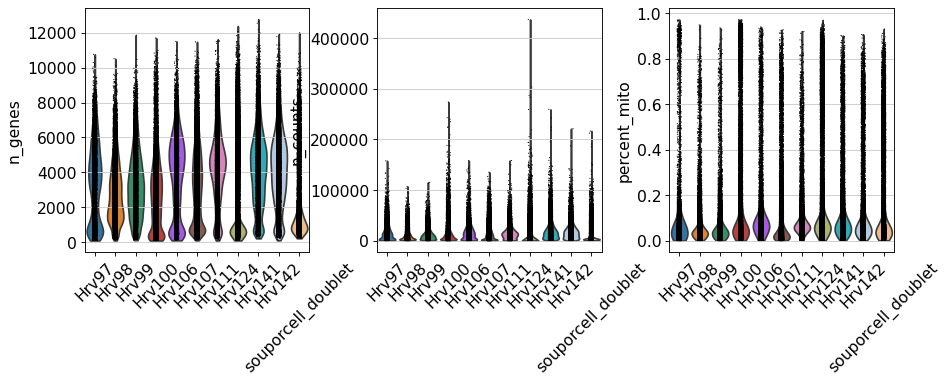

In [134]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_souporcell', rotation=45, save='_before_qc.pdf') 

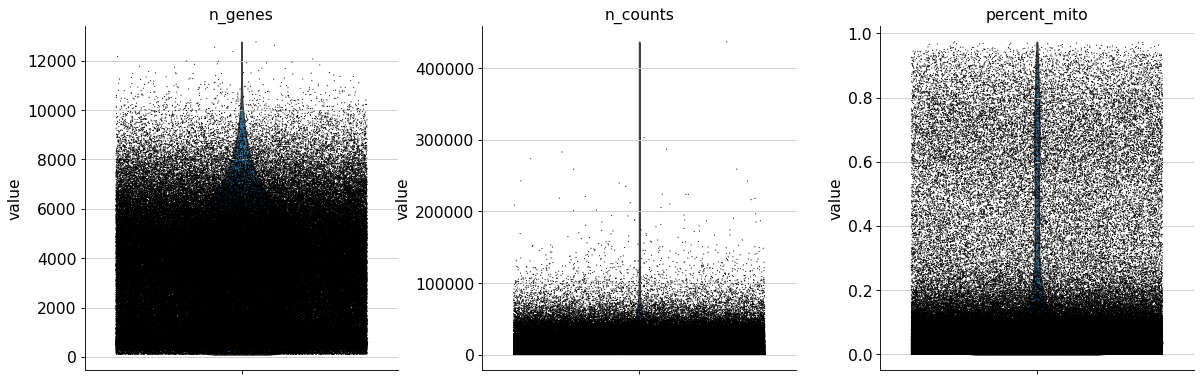

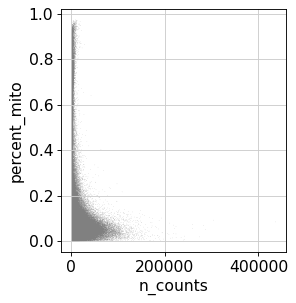

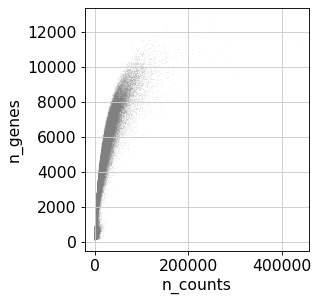

In [135]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf')
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf')
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf')

### Filtering the number of genes

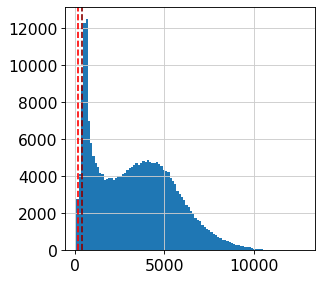

In [136]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(200, linestyle = '--', color = 'red')
plt.axvline(400, linestyle = '--', color = 'darkred')

In [137]:
#deleting the cells expressing less than 400 genes
sc.pp.filter_cells(adata, min_genes=400)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


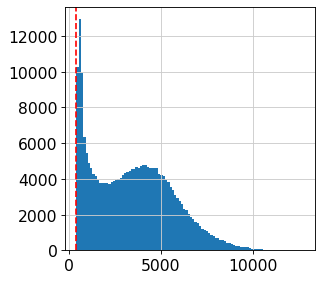

In [138]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(400, linestyle = '--', color = 'red')

In [139]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_souporcell'].values.describe()

Total number of cells: 244222
Total number of genes: 32743


,counts,freqs
categories,,
Hrv97,9206,0.037695
Hrv98,24198,0.099082
Hrv99,19582,0.080181
Hrv100,21019,0.086065
Hrv106,12304,0.050380
Hrv107,38648,0.158249
Hrv111,21302,0.087224
Hrv124,32039,0.131188
Hrv141,25335,0.103738



### Filter cells by counts

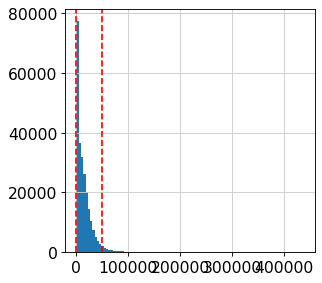

In [140]:
plt.hist(adata.obs['n_counts'], bins = 100)
plt.axvline(300, linestyle = '--', color = 'red')
plt.axvline(50000, linestyle = '--', color = 'red')

In [141]:
sc.pp.filter_cells(adata, min_counts = 300)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

#sc.pp.filter_cells(adata, max_counts = 50000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Number of cells after min count filter: 244222


In [142]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 244222
Total number of genes: 32743



### Filter cells with large % mitochondrial genes

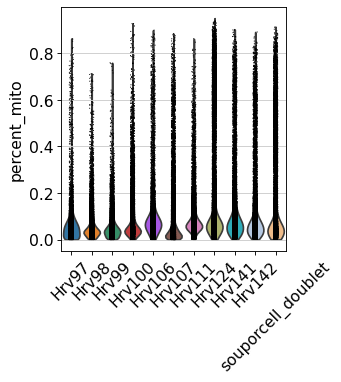

In [143]:
sc.pl.violin(adata, ['percent_mito'], groupby='donor_souporcell', rotation=45 ) #hPGCs

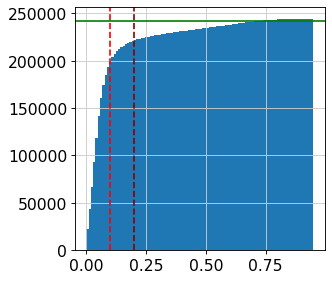

In [144]:
#Histogram Y number of cells, X mitocondrial percentage
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [145]:
# Keeping cells with <10%
adata = adata[adata.obs['percent_mito'] < 0.1, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [146]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 196363
Total number of genes: 32743


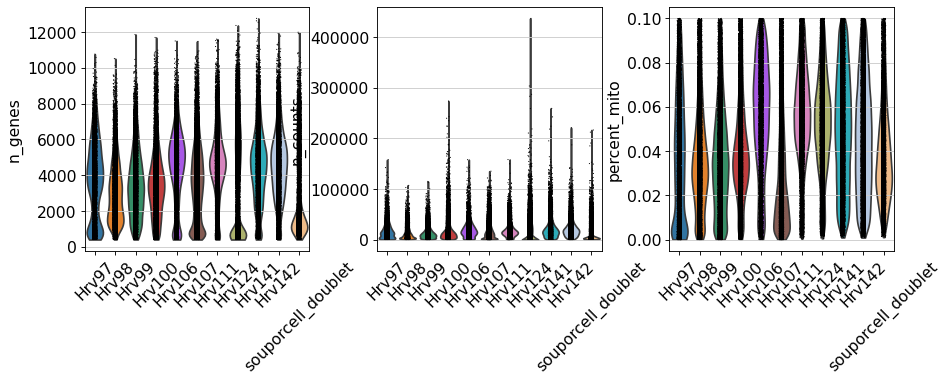

In [147]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_souporcell', rotation=45, save='_after_qc.pdf') 

In [148]:
adata.obs['sample'].values.describe()

,counts,freqs
categories,,
Pla_HDBR10917729,7954,0.040507
Pla_HDBR10917730,12981,0.066107
Pla_HDBR10917731,11866,0.060429
Pla_HDBR10917732,21235,0.108142
Pla_HDBR10917733,15284,0.077835
Pla_HDBR10917734,1447,0.007369
Pla_HDBR11345027,8891,0.045278
Pla_HDBR11345028,11412,0.058117
Pla_HDBR11345030,23326,0.118790


In [149]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_souporcell'].values.describe()

Total number of cells: 196363
Total number of genes: 32743


,counts,freqs
categories,,
Hrv97,7954,0.040507
Hrv98,21841,0.111228
Hrv99,17684,0.090058
Hrv100,16731,0.085204
Hrv106,8891,0.045278
Hrv107,34738,0.176907
Hrv111,17000,0.086574
Hrv124,22642,0.115307
Hrv141,18571,0.094575



### Saving raw counts

In [150]:
adata_original = adata.copy()
adata_original.write('../data/S1_preprocessed_noNormalized_adata_20220523.h5ad')
#adata=sc.read('../data/S1_preprocessed_noNormalized_adata_20220522.h5ad.h5ad')

In [13]:
adata=sc.read('../data/S1_preprocessed_noNormalized_adata_20220523.h5ad')

In [17]:
adata_original = adata.copy()

In [151]:
#adata= adata_original.copy()

In [4]:
adata

AnnData object with n_obs × n_vars = 149617 × 31625
    obs: 'n_genes', 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'souporcell_id', 'donor_deconv', 'donor_souporcell', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9'
    uns: 'donor_souporcell_colors'

## Highly variable genes


In [65]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


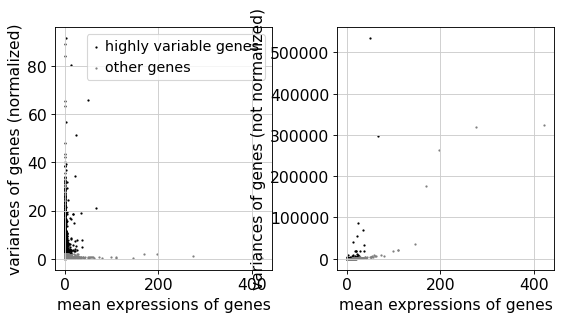

Total number of cells: 196363
Total number of genes: 3000


In [152]:
#  HVGs. Seurat 3 expects non-normalized counts
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata)

#saving the highl variable genes
highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

### Saving the annotation of HVGs

In [153]:
adata.var.to_csv('../results/tables/highlyVariable_genes.csv')

In [68]:
#adata_original = adata_original[:, highly_variable_genes]

In [64]:
#adata=sc.read('../data/S1_preprocessed_noNormalized_adata.h5ad')

In [65]:
#adata_original.write('../data/S1_preprocessed_noNormalized_highVarGenes_adata.h5ad')

## Calculate cell-cycle scores AND (optional)regress out cell cycle genes
We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

In [154]:
adata= adata_original.copy()

In [18]:
#Normalizing the data and scaling for the cell-cycle scoring
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


# Scale
sc.pp.scale(adata, max_value=10)
adata

AnnData object with n_obs × n_vars = 196363 × 32743
    obs: 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'souporcell_id', 'donor_deconv', 'donor_souporcell', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mean', 'std'
    uns: 'donor_souporcell_colors', 'log1p'

In [19]:
# Calculate cell cycle genes
cell_cycle_genes = [x.strip() for x in open(data_dir+'regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score']

In [20]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 196363
Total number of genes: 32743


,counts,freqs
categories,,
Pla_HDBR10917729,7954,0.040507
Pla_HDBR10917730,12981,0.066107
Pla_HDBR10917731,11866,0.060429
Pla_HDBR10917732,21235,0.108142
Pla_HDBR10917733,15284,0.077835
Pla_HDBR10917734,1447,0.007369
Pla_HDBR11345027,8891,0.045278
Pla_HDBR11345028,11412,0.058117
Pla_HDBR11345030,23326,0.118790


In [21]:
# Adding the cell cycle annotation to the original object
adata_original.obs= adata.obs

In [23]:
adata_original.obs

,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,n_genes,sample_barcode,...,donor_souporcell,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,S_score,G2M_score,phase
Pla_HDBR10917729_AAACCCACATCGAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,1938,Pla_HDBR10917729_AAACCCACATCGAACT,...,Hrv97,0.057737,0.054764,-0.327300,0.894339,1.0,False,0.145270,-0.228714,S
Pla_HDBR10917729_AAACCCAGTAAGACCG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,449,Pla_HDBR10917729_AAACCCAGTAAGACCG,...,Hrv97,0.012195,0.019366,-1.455072,0.939430,1.0,False,0.136907,0.299731,G2M
Pla_HDBR10917729_AAACCCAGTGGGATTG,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,779,Pla_HDBR10917729_AAACCCAGTGGGATTG,...,Hrv97,0.054764,0.054764,-0.327300,0.894339,1.0,False,0.025165,-0.084019,S
Pla_HDBR10917729_AAACGAAAGCCTAACT,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047304,3023.0,0,1178,Pla_HDBR10917729_AAACGAAAGCCTAACT,...,Hrv97,0.024876,0.024486,-1.291958,0.939430,1.0,False,0.575056,0.865733,G2M
Pla_HDBR10917729_AAACGAAAGCCTGGAA,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.066152,11005.0,0,3605,Pla_HDBR10917729_AAACGAAAGCCTGGAA,...,Hrv97,0.107930,0.101911,1.174823,0.883925,1.0,False,0.062936,-0.146854,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR12808831_TTTGTTGTCCAAGAGG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,12pcw,0.077964,14404.0,15,4058,Pla_HDBR12808831_TTTGTTGTCCAAGAGG,...,Hrv142,NaN,NaN,NaN,NaN,NaN,False,-0.045314,0.148042,G2M
Pla_HDBR12808831_TTTGTTGTCGGTCATA,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw_12pcw,0.046711,4089.0,15,1990,Pla_HDBR12808831_TTTGTTGTCGGTCATA,...,souporcell_doublet,NaN,NaN,NaN,NaN,NaN,False,-0.222882,-0.077481,G1
Pla_HDBR12808831_TTTGTTGTCTCGACGG,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,12pcw,0.021751,19355.0,15,4116,Pla_HDBR12808831_TTTGTTGTCTCGACGG,...,Hrv142,NaN,NaN,NaN,NaN,NaN,False,-0.086242,-0.144484,G1
Pla_HDBR12808831_TTTGTTGTCTGTGCTC,Pla_HDBR12808831,Hrv141+Hrv142,surgical,d2,14pcw,0.039958,23550.0,15,5239,Pla_HDBR12808831_TTTGTTGTCTGTGCTC,...,Hrv141,NaN,NaN,NaN,NaN,NaN,False,-0.157663,-0.152948,G1


## Saving data

In [17]:
#Saving raw counts with the new cell cycle annotation
adata_original.write('../data/S1_preprocessed_noNormalized_adata_20220523.h5ad')

In [24]:
## Saving only the DF with the cellcycle score and the classification. TO be use in the future
metadata= adata.obs
metadata[['donor_souporcell','S_score','G2M_score','phase']].to_csv('../results/tables/cellCycle_score.csv')